In [1]:
import networkx as nx
import pandas as pd

# Load citation edges
edges = []
with open("C:\\Users\\YuxinLi\\Downloads\\hep-th-citations.txt", "r") as f:
    for line in f:
        src, tgt = line.strip().split()
        edges.append((src, tgt))

# Create directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Load date attributes
dates = {}
with open("C:\\Users\\YuxinLi\\Downloads\\hep-th-slacdates.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            paper_id, date = parts
            dates[paper_id] = date

# Assign date attributes only to nodes in the citation network
for node in G.nodes:
    if node in dates:
        G.nodes[node]['date'] = dates[node]

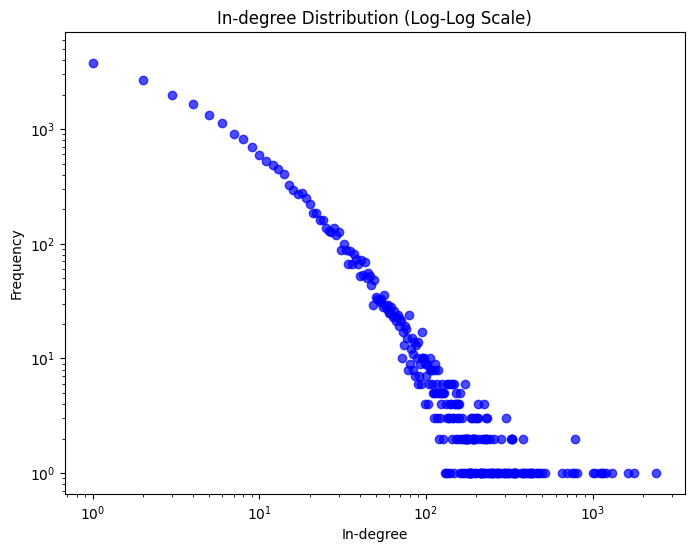

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate in-degree for each node
in_degrees = [d for n, d in G.in_degree()]

# Count frequency of each in-degree
degree_counts = np.bincount(in_degrees)
degrees = np.arange(len(degree_counts))

# Only plot degrees with nonzero count
nonzero = degree_counts > 0

plt.figure(figsize=(8, 6))
plt.scatter(degrees[nonzero], degree_counts[nonzero], color='blue', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('In-degree')
plt.ylabel('Frequency')
plt.title('In-degree Distribution (Log-Log Scale)')
plt.show()

In [3]:
def mle_power_law(degrees):
    # Remove zeros
    degrees = np.array(degrees)
    degrees = degrees[degrees > 0]
    n = len(degrees)
    if n == 0:
        return None
    return 1 + n / np.sum(np.log(degrees / degrees.min()))

# Extract in-degrees and calculate MLE estimator
in_degrees = [d for n, d in G.in_degree()]
alpha_mle = mle_power_law(in_degrees)
print(f"MLE estimator of power law exponent: {alpha_mle:.4f}")

MLE estimator of power law exponent: 1.5565


In [5]:
import powerlaw

# Extract in-degrees and remove zeros
in_degrees = np.array([d for n, d in G.in_degree()])
in_degrees = in_degrees[in_degrees > 0]

# Fit power law using the powerlaw package
fit = powerlaw.Fit(in_degrees, discrete=True)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin

print(f"Powerlaw package estimate: alpha = {alpha:.4f}, xmin = {xmin}")

Calculating best minimal value for power law fit
Powerlaw package estimate: alpha = 2.6954, xmin = 54.0


In [6]:
# Filter in-degrees to only those >= xmin
filtered_degrees = in_degrees[in_degrees >= xmin]

# Calculate MLE estimator using our function
alpha_mle_xmin = mle_power_law(filtered_degrees)
print(f"MLE estimator using xmin={xmin}: alpha = {alpha_mle_xmin:.4f}")

MLE estimator using xmin=54.0: alpha = 2.7225


In [10]:
# PDF with linear bins
plt.figure(figsize=(8, 6))
fit.plot_pdf(color='blue', label='PDF (linear bins)', linear_bins=True)
fit.power_law.plot_pdf(color='red', linestyle='--', label=f'Power Law Fit (alpha={alpha:.2f})')
plt.xlabel('In-degree')
plt.ylabel('Probability')
plt.title('PDF (Linear Bins)')
plt.legend()
plt.show()

In [12]:
# PDF with log bins
plt.figure(figsize=(8, 6))
fit.plot_pdf(color='blue', label='PDF (log bins)', linear_bins=False)
fit.power_law.plot_pdf(color='red', linestyle='--', label=f'Power Law Fit (alpha={alpha:.2f})')
plt.xlabel('In-degree')
plt.ylabel('Probability')
plt.title('PDF (Log Bins)')
plt.legend()
plt.show()

In [14]:
# CDF
plt.figure(figsize=(8, 6))
fig = fit.plot_cdf(color='blue', label='CDF')
fit.power_law.plot_cdf(color='red', linestyle='--', label=f'Power Law Fit (alpha={alpha:.2f})', ax=fig)
plt.xlabel('In-degree')
plt.ylabel('CDF')
plt.title('CDF of In-degree Distribution')
plt.legend()
plt.show()

In [15]:
# 1-CDF (Survival function)
plt.figure(figsize=(8, 6))
fig = fit.plot_ccdf(color='red', label='1-CDF (CCDF)')
fit.power_law.plot_ccdf(color='blue', linestyle='--', label=f'Power Law Fit (alpha={alpha:.2f})', ax=fig)
plt.xlabel('In-degree')
plt.ylabel('1-CDF')
plt.title('1-CDF (CCDF) of In-degree Distribution')
plt.legend()
plt.show()

In [20]:
# Read CSV files
vertices_df = pd.read_csv("C:\\Users\\YuxinLi\\Downloads\\gridkit_europe-highvoltage-vertices.csv")
edges_df = pd.read_csv("C:\\Users\\YuxinLi\\Downloads\\gridkit_europe-highvoltage-links.csv")

# Create a graph
G = nx.Graph()

# Add vertices with attributes
for _, row in vertices_df.iterrows():
    node_id = row['v_id']
    attrs = row.drop('v_id').to_dict()
    G.add_node(node_id, **attrs)

# Add edges with attributes
for _, row in edges_df.iterrows():
    source = row['v_id_1']
    target = row['v_id_2']
    attrs = row.drop(['v_id_1', 'v_id_2']).to_dict()
    G.add_edge(source, target, **attrs)

# Print the graph summary
print(G)

Graph with 13871 nodes and 17277 edges


In [21]:
# Number of nodes and edges in the European power grid
n_nodes = len(G.nodes)
n_edges = len(G.edges)

# Average degree: 2 * number of edges / number of nodes
avg_degree = 2 * n_edges / n_nodes

# Area of unit square is 1, so: n_nodes * pi * r^2 = avg_degree
radius = np.sqrt(avg_degree / (np.pi * n_nodes))

# Generate random geometric graph
G_geo = nx.random_geometric_graph(n_nodes, radius)

print(f"Random geometric graph: {G_geo.number_of_nodes()} nodes, {G_geo.number_of_edges()} edges, radius={radius:.4f}")

Random geometric graph: 13871 nodes, 17131 edges, radius=0.0076


In [22]:
# Size of largest connected component in the European power grid
largest_cc_grid = max(nx.connected_components(G), key=len)
size_largest_cc_grid = len(largest_cc_grid)
print(f"Largest connected component (European grid): {size_largest_cc_grid}")

# Size of largest connected component in the random geometric graph
largest_cc_geo = max(nx.connected_components(G_geo), key=len)
size_largest_cc_geo = len(largest_cc_geo)
print(f"Largest connected component (Random geometric graph): {size_largest_cc_geo}")

Largest connected component (European grid): 13478
Largest connected component (Random geometric graph): 72


In [23]:
# Compare cluster coefficient (transitivity)
trans_grid = nx.transitivity(G)
trans_geo = nx.transitivity(G_geo)

print(f"Transitivity (European grid): {trans_grid:.4f}")
print(f"Transitivity (Random geometric graph): {trans_geo:.4f}")

Transitivity (European grid): 0.1001
Transitivity (Random geometric graph): 0.5834


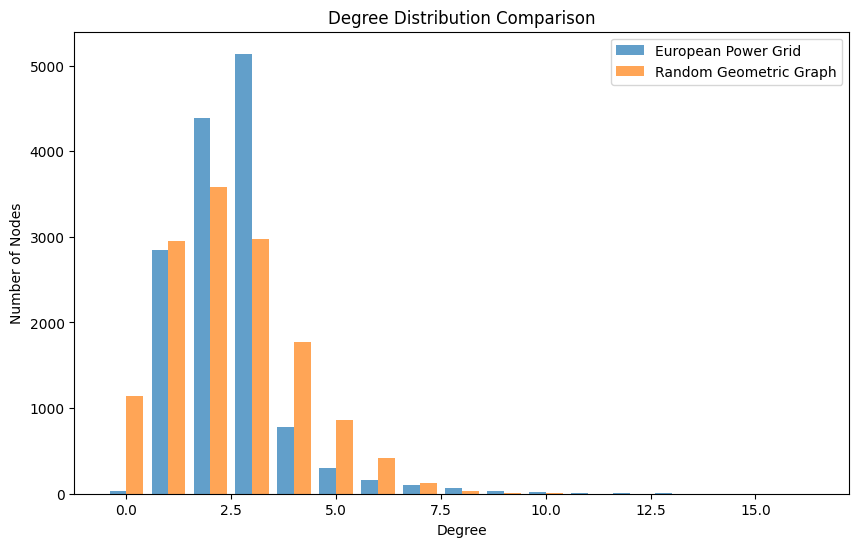

In [24]:
# Degree distributions
degrees_grid = [d for n, d in G.degree()]
degrees_geo = [d for n, d in G_geo.degree()]

# Count frequency of each degree
max_degree = max(max(degrees_grid), max(degrees_geo))
counts_grid = np.bincount(degrees_grid, minlength=max_degree+1)
counts_geo = np.bincount(degrees_geo, minlength=max_degree+1)
x = np.arange(max_degree + 1)

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, counts_grid, width=0.4, label='European Power Grid', alpha=0.7)
plt.bar(x + 0.2, counts_geo, width=0.4, label='Random Geometric Graph', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.show()

In [25]:
# Generate random geometric graph
G_geo_new = nx.random_geometric_graph(n_nodes, radius*1.5)

print(f"Random geometric graph: {G_geo_new.number_of_nodes()} nodes, {G_geo_new.number_of_edges()} edges, radius={radius*1.5:.4f}")

Random geometric graph: 13871 nodes, 38731 edges, radius=0.0113


In [26]:
# Size of largest connected component in the random geometric graph
largest_cc_geo = max(nx.connected_components(G_geo_new), key=len)
size_largest_cc_geo = len(largest_cc_geo)
print(f"Largest connected component (Random geometric graph): {size_largest_cc_geo}")

Largest connected component (Random geometric graph): 13457


In [27]:
trans_geo = nx.transitivity(G_geo_new)

print(f"Transitivity (Random geometric graph): {trans_geo:.4f}")

Transitivity (Random geometric graph): 0.5903


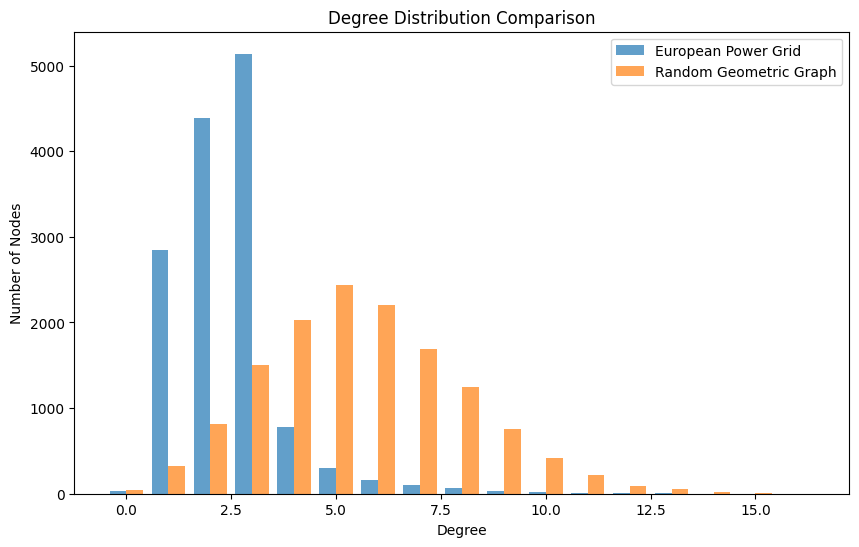

In [28]:
# Degree distributions
degrees_grid = [d for n, d in G.degree()]
degrees_geo = [d for n, d in G_geo_new.degree()]

# Count frequency of each degree
max_degree = max(max(degrees_grid), max(degrees_geo))
counts_grid = np.bincount(degrees_grid, minlength=max_degree+1)
counts_geo = np.bincount(degrees_geo, minlength=max_degree+1)
x = np.arange(max_degree + 1)

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, counts_grid, width=0.4, label='European Power Grid', alpha=0.7)
plt.bar(x + 0.2, counts_geo, width=0.4, label='Random Geometric Graph', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.show()

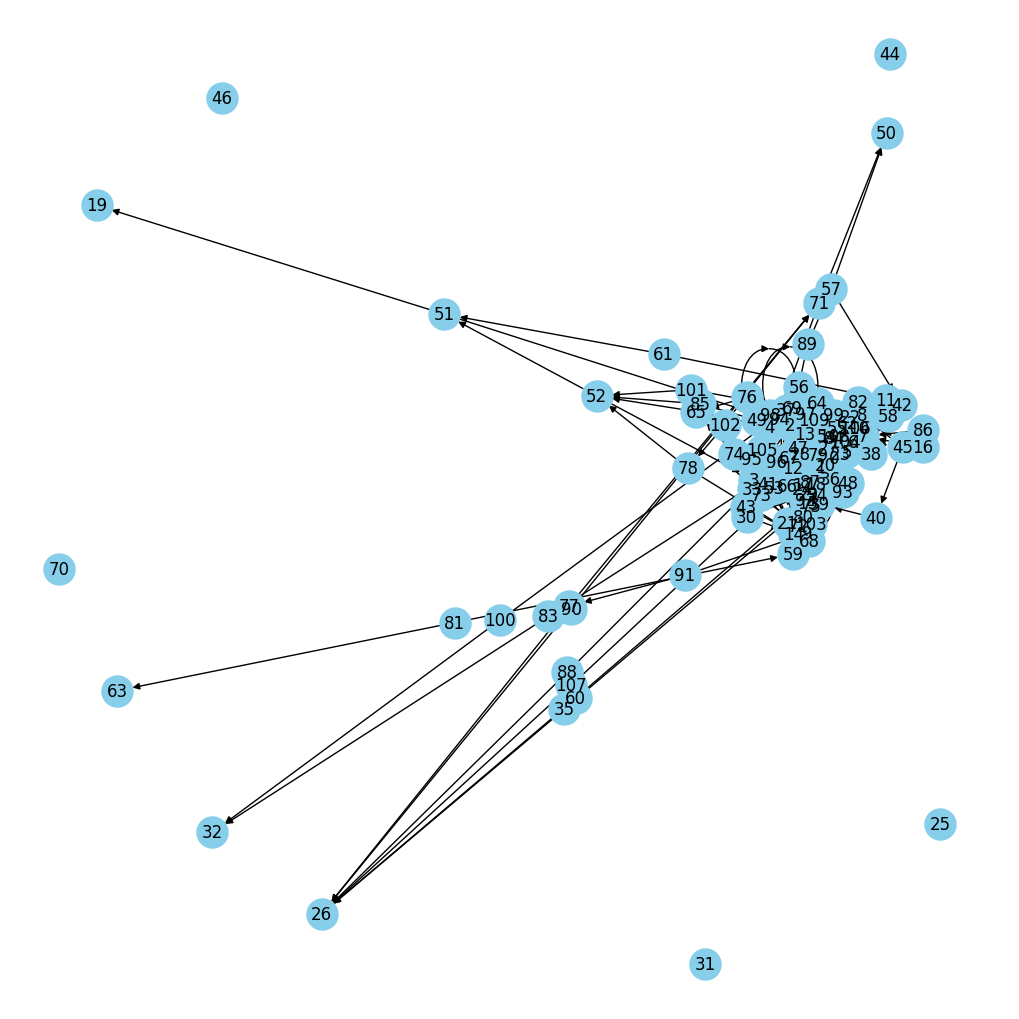

In [29]:
import random

def node_copy_model(n0, m, gamma, num_steps):
  # Initialize the network with n0 nodes, each having out-degree m
  G = nx.DiGraph()
  for i in range(n0):
    G.add_node(i)
  for i in range(n0):
    targets = random.sample(range(n0), m)
    for target in targets:
      G.add_edge(i, target)
  
  # Add new nodes to the network
  for new_node in range(n0, n0 + num_steps):
    G.add_node(new_node)
    # Choose a previous node uniformly at random
    chosen_node = random.choice(list(G.nodes))
    neighbors = list(G.successors(chosen_node))
    for neighbor in neighbors:
      if random.random() < gamma:
        G.add_edge(new_node, neighbor)
      else:
        potential_targets = set(G.nodes) - set(neighbors) - {new_node}
        if potential_targets:
          random_target = random.choice(list(potential_targets))
          G.add_edge(new_node, random_target)
  
  return G

# Example usage
n0 = 10
m = 2
gamma = 0.5
num_steps = 100
G = node_copy_model(n0, m, gamma, num_steps)

# Visualize the network
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=500, node_color="skyblue", pos=nx.spring_layout(G))
plt.show()

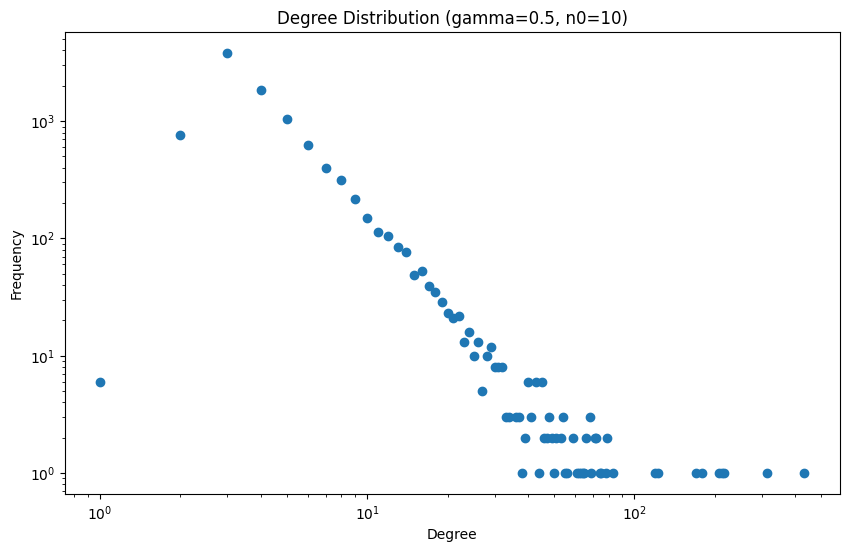

Calculating best minimal value for power law fit
Estimated scaling exponent: 3.127560483727339
Estimated minimum degree used: 12.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [30]:
from scipy.optimize import curve_fit

G = node_copy_model(10, 3, 0.5, 10000)

# Extract the degrees
degrees = [degree for node, degree in G.degree()]

# Calculate the degree distribution
degree_distribution = nx.degree_histogram(G)

# Visualize the degree distribution using a scatter plot on a log-log scale
plt.figure(figsize=(10, 6))
plt.scatter(range(len(degree_distribution)), degree_distribution, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title(f'Degree Distribution (gamma={gamma}, n0={n0})')
plt.show()

# Fit a power-law function to the degree distribution
fit = powerlaw.Fit(degrees)
alpha = fit.alpha
xmin = fit.xmin
print(f'Estimated scaling exponent: {alpha}')
print(f'Estimated minimum degree used: {xmin}')

In [32]:
# Load the protein interaction network into a pandas dataframe
df = pd.read_csv('C:\\Users\\YuxinLi\\Downloads\\6239.protein.links.v12.0.csv')

# Generate an undirected graph from the edgelist using "from_edgelist"
G = nx.from_pandas_edgelist(df, source='protein1', target='protein2', create_using=nx.Graph())

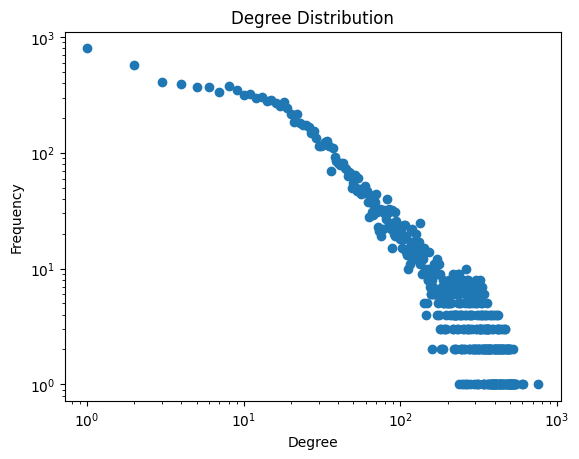

In [33]:
# Extract the degrees
degrees = [degree for node, degree in G.degree()]

# Calculate the degree distribution
degree_distribution = nx.degree_histogram(G)

# Visualize the degree distribution using a scatter plot on a log-log scale
import matplotlib.pyplot as plt

plt.scatter(range(len(degree_distribution)), degree_distribution, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

In [34]:
# Load the Drosophila medulla network from the graphml file
G = nx.read_graphml('C:\\Users\\YuxinLi\\Downloads\\drosophila_medulla_1.graphml')

print(G)

MultiDiGraph with 1781 nodes and 33641 edges


In [35]:
# Calculate the average 3D coordinates for each node
for node in G.nodes:
  x = []
  y = []
  z = []
  
  # Collect the pre- and post-synaptic coordinates for the node
  for edge in G.edges:
    if edge[1] == node:
      x.append(G.edges[edge]['post.x'])
      y.append(G.edges[edge]['post.y'])
      z.append(G.edges[edge]['post.z'])
  
  if len(x) > 0:
    # Calculate the average coordinates
    avg_x = sum(x) / len(x) 
    avg_y = sum(y) / len(y) 
    avg_z = sum(z) / len(z)

    # Set the new node attribute for the average coordinates
    G.nodes[node]['coordinate'] = (avg_x, avg_y, avg_z)

# Remove nodes without coordinates
no_coordinates = [node for node in G.nodes if 'coordinate' not in G.nodes[node]]
G.remove_nodes_from(no_coordinates)

# Print the updated graph
G = nx.Graph(G)
print(G)

Graph with 1155 nodes and 7557 edges


In [36]:
# Pick a node to draw edges for
import random

# Pick a random node as the selected node
selected_node = random.choice(list(G.nodes))

# Get the x and y coordinates of all nodes
node_positions = {node: (G.nodes[node]['coordinate'][0], G.nodes[node]['coordinate'][1]) for node in G.nodes}

# Draw the network with node positions and only edges connected to the selected node
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos=node_positions, node_size=10, alpha=0.8)
nx.draw_networkx_edges(G, pos=node_positions, edgelist=G.edges(selected_node), width=1, alpha=0.5)
plt.axis('off')
plt.title('Drosophila Medulla Network')
plt.show()

In [37]:
# Generate a Random Geometry Network (RGN) in three dimensions with the same number of nodes and average number of edges
avg_d = sum([d for (_,d) in G.degree()]) / len(G.nodes)
r = (avg_d / (4/3 * 3.141 * (len(G.nodes)-1)))**(1/3)

RGN = nx.random_geometric_graph(n=len(G.nodes), radius=1.06 * r, dim=3)

print(G)
print(RGN)

Graph with 1155 nodes and 7557 edges
Graph with 1155 nodes and 7440 edges


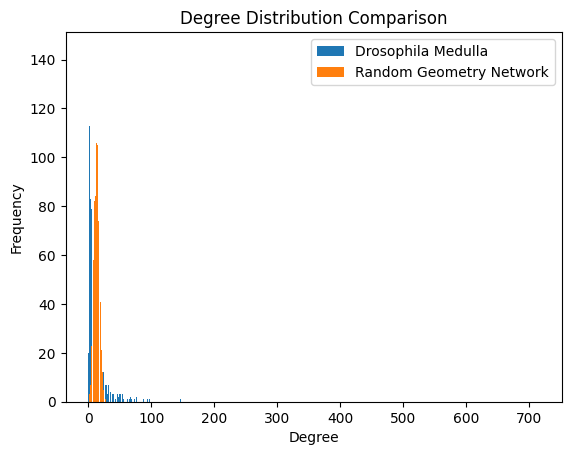

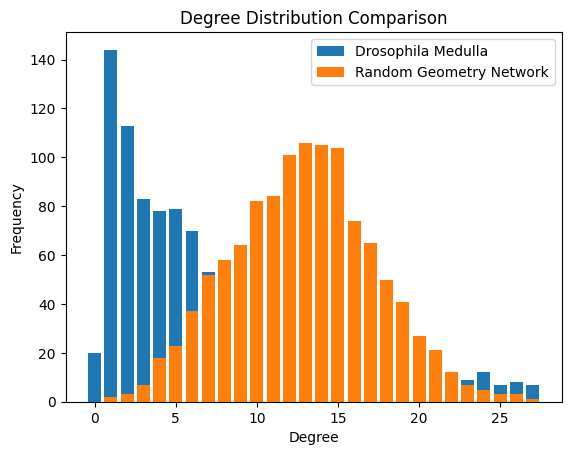

In [38]:
# Extract the degrees of the Drosophila medulla network

degrees_medulla = [degree for node, degree in G.degree()]
degrees_RGN = [degree for node, degree in RGN.degree()]

# Calculate the degree distribution of the Drosophila medulla network
degree_distribution_medulla = nx.degree_histogram(G)
degree_distribution_RGN = nx.degree_histogram(RGN)

# Plot the degree distribution of the Drosophila medulla network
plt.bar(range(len(degree_distribution_medulla)), degree_distribution_medulla, label='Drosophila Medulla')

# Plot the degree distribution of the Random Geometry Network (RGN)
plt.bar(range(len(degree_distribution_RGN)), degree_distribution_RGN, label='Random Geometry Network')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.show()


# Plot the degree distribution of the Drosophila medulla network
plt.bar(range(len(degree_distribution_RGN)), degree_distribution_medulla[:len(degree_distribution_RGN)], label='Drosophila Medulla')

# Plot the degree distribution of the Random Geometry Network (RGN)
plt.bar(range(len(degree_distribution_RGN)), degree_distribution_RGN, label='Random Geometry Network')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.show()

In [39]:
import pandas as pd

# Load the Facebook wall post edge list
# Assumption: the data folder is two levels up from this notebook's directory.
# Adjust the relative path if your folder structure differs.
edge_path = 'C:\\Users\\YuxinLi\\Downloads\\facebook-wall.txt'

# The file is assumed to be tab-separated with three columns: source, target, timestamp
edges = pd.read_csv(edge_path, sep='\t', header=None, names=['source', 'target', 'timestamp'])

# Show the first few rows
edges.head()

source  target   timestamp
0      28      28  1095135831
1    1015    1017  1097725406
2     959     959  1098387569
3     991     991  1098425204
4    1015    1017  1098489762

In [40]:
# Convert Unix timestamps to timezone-aware datetime
edges['datetime'] = pd.to_datetime(edges['timestamp'], unit='s', utc=True)

# Define period boundaries
start_2008 = pd.Timestamp('2008-01-01', tz='UTC')
start_2009 = pd.Timestamp('2009-01-01', tz='UTC')

# Split into past (before 2008) and future (during 2008)
past_edges = edges[edges['datetime'] < start_2008].copy()
future_edges = edges[(edges['datetime'] >= start_2008) & (edges['datetime'] < start_2009)].copy()

# Quick summary output
print('Past edges (before 2008):', past_edges.shape[0])
print('Future edges (during 2008):', future_edges.shape[0])

display(past_edges.head())
display(future_edges.head())

Past edges (before 2008): 377660
Future edges (during 2008): 448831


source  target   timestamp                  datetime
0      28      28  1095135831 2004-09-14 04:23:51+00:00
1    1015    1017  1097725406 2004-10-14 03:43:26+00:00
2     959     959  1098387569 2004-10-21 19:39:29+00:00
3     991     991  1098425204 2004-10-22 06:06:44+00:00
4    1015    1017  1098489762 2004-10-23 00:02:42+00:00

source  target   timestamp                  datetime
377660    4295    2412  1199145905 2008-01-01 00:05:05+00:00
377661   13711    5283  1199145956 2008-01-01 00:05:56+00:00
377662   10632    2278  1199145981 2008-01-01 00:06:21+00:00
377663    1296   16192  1199146048 2008-01-01 00:07:28+00:00
377664   21543   20071  1199146152 2008-01-01 00:09:12+00:00

In [41]:
# Build directed graph from past edges
G_past = nx.from_pandas_edgelist(
    past_edges,
    source='source',
    target='target',
    create_using=nx.DiGraph()
)

# Compute in-degree and out-degree
in_deg = dict(G_past.in_degree())
out_deg = dict(G_past.out_degree())

# Assemble metrics DataFrame
nodes = sorted(G_past.nodes())
metrics_df = pd.DataFrame({
    'node': nodes,
    'in_degree': [in_deg.get(n, 0) for n in nodes],
    'out_degree': [out_deg.get(n, 0) for n in nodes]
})

metrics_df.head()

node  in_degree  out_degree
0     1          2           4
1     2          4           3
2     3          4           0
3     5          0           2
4     6          6           9

In [42]:
# Count future incoming posts (receiver = target column in our DataFrame)
future_counts = future_edges['target'].value_counts().rename('future_success')

# Merge into metrics_df (left join keeps all past nodes)
metrics_df = metrics_df.merge(future_counts, left_on='node', right_index=True, how='left')
metrics_df['future_success'] = metrics_df['future_success'].fillna(0).astype(int)

# Preview
metrics_df.head()

node  in_degree  out_degree  future_success
0     1          2           4               6
1     2          4           3               9
2     3          4           0               2
3     5          0           2              14
4     6          6           9               8

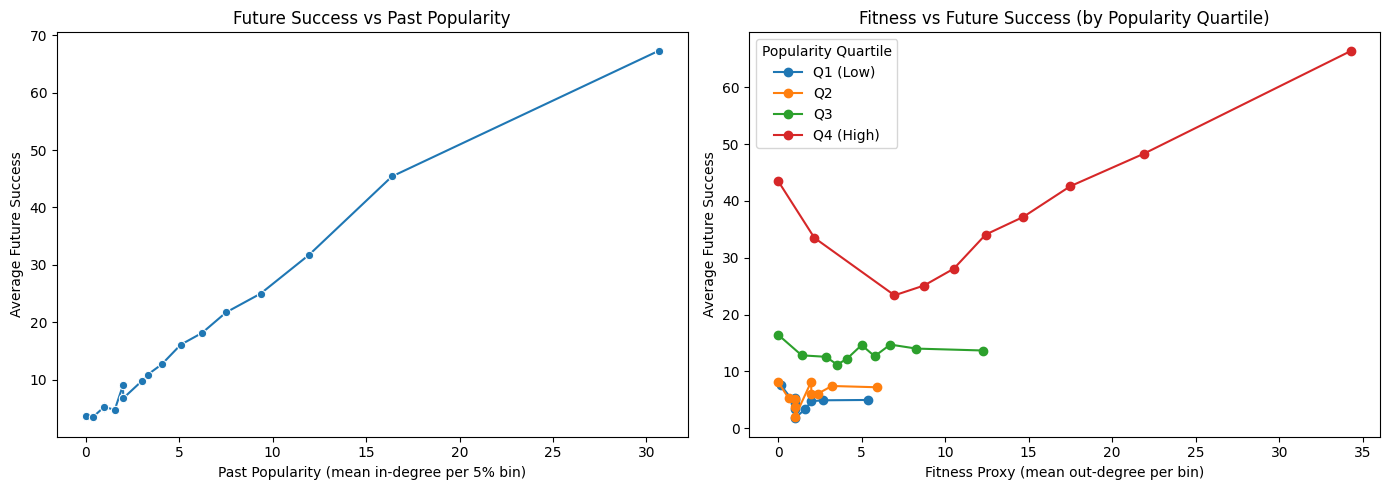

(   pop_bin  mean_in_degree  avg_future_success
 0        0        0.000000            4.040675
 1        1        0.000000            3.246276
 2        2        0.400199            3.498510
 3        3        1.000000            5.762661
 4        4        1.000000            6.206554,
   pop_quartile  fitness_bin  mean_out_degree  avg_future_success
 0     Q1 (Low)            0         0.170635            7.569444
 1     Q1 (Low)            1         1.000000            4.373016
 2     Q1 (Low)            2         1.000000            5.335984
 3     Q1 (Low)            3         1.000000            5.039683
 4     Q1 (Low)            4         1.000000            3.465209)

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Left Panel: Future success vs past popularity (20 quantile bins) ---
# Create 20 approximately equal-sized quantile bins (5-percentile steps)
pop_q = pd.qcut(
    metrics_df['in_degree'].rank(method='first'),
    q=20,
    duplicates='drop'
)
metrics_df['pop_bin'] = pop_q.cat.codes

pop_agg = (metrics_df
    .groupby('pop_bin', as_index=False, observed=False)
    .agg(mean_in_degree=('in_degree', 'mean'),
         avg_future_success=('future_success', 'mean')))

# --- Right Panel: Within popularity quartiles, fitness (out_degree) vs future success ---
# Popularity quartiles
metrics_df['pop_quartile'] = pd.qcut(
    metrics_df['in_degree'].rank(method='first'),
    q=4,
    labels=['Q1 (Low)','Q2','Q3','Q4 (High)'],
    duplicates='drop'
)

# For each popularity quartile, bin fitness (out_degree) into up to 10 quantile bins
# (If fewer unique values exist, bins will be fewer due to duplicates='drop')
def fitness_binner(s):
    return pd.qcut(s.rank(method='first'), q=min(10, s.nunique()), labels=False, duplicates='drop')

metrics_df['fitness_bin'] = metrics_df.groupby('pop_quartile', group_keys=False, observed=False)['out_degree'].apply(fitness_binner)

fitness_agg = (metrics_df
    .dropna(subset=['fitness_bin'])
    .groupby(['pop_quartile','fitness_bin'], as_index=False, observed=False)
    .agg(mean_out_degree=('out_degree','mean'),
         avg_future_success=('future_success','mean')))

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel
sns.lineplot(data=pop_agg, x='mean_in_degree', y='avg_future_success', marker='o', ax=axes[0])
axes[0].set_xlabel('Past Popularity (mean in-degree per 5% bin)')
axes[0].set_ylabel('Average Future Success')
axes[0].set_title('Future Success vs Past Popularity')

# Right panel: overlay lines for each quartile
for quartile, sub in fitness_agg.groupby('pop_quartile', observed=False):
    axes[1].plot(sub['mean_out_degree'], sub['avg_future_success'], marker='o', label=str(quartile))

axes[1].set_xlabel('Fitness Proxy (mean out-degree per bin)')
axes[1].set_ylabel('Average Future Success')
axes[1].set_title('Fitness vs Future Success (by Popularity Quartile)')
axes[1].legend(title='Popularity Quartile')

plt.tight_layout()
plt.show()

# Show head of aggregation tables for reference
pop_agg.head(), fitness_agg.head()

In [46]:
# Load CSV files (assumes they are in the same directory as this notebook)
nodes_a = pd.read_csv("C:\\Users\\YuxinLi\\Downloads\\mole_network_a_nodes.csv")
edges_a = pd.read_csv("C:\\Users\\YuxinLi\\Downloads\\mole_network_a_edges.csv")
nodes_b = pd.read_csv("C:\\Users\\YuxinLi\\Downloads\\mole_network_b_nodes.csv")
edges_b = pd.read_csv("C:\\Users\\YuxinLi\\Downloads\\mole_network_b_edges.csv")

# Optional: quick peek at the first few rows (uncomment if desired)
display(nodes_a.head())
display(edges_a.head())
display(nodes_b.head())
display(edges_b.head())

id    x    y
0  A1  0.8  9.6
1  A2  2.1  9.2
2  A3  3.0  8.8
3  A4  5.5  8.9
4  A5  7.8  9.5

source target
0     A1     A2
1     A2     A3
2     A3     A4
3     A4     A5
4     A5     A6

id    x    y
0  B1  1.0  9.0
1  B2  2.5  9.2
2  B3  4.0  8.8
3  B4  6.0  9.0
4  B5  8.0  8.5

source target
0     B1     B2
1     B2     B3
2     B3     B4
3     B4     B5
4     B5     B6

In [47]:
G_a = nx.from_pandas_edgelist(edges_a, source='source', target='target', create_using=nx.Graph())
G_b = nx.from_pandas_edgelist(edges_b, source='source', target='target', create_using=nx.Graph())

for _, r in nodes_a.iterrows():
    G_a.add_node(r['id'], x=r['x'], y=r['y'])
for _, r in nodes_b.iterrows():
    G_b.add_node(r['id'], x=r['x'], y=r['y'])

# Quick size checks
print(G_a)
print(G_b)

Graph with 20 nodes and 30 edges
Graph with 30 nodes and 45 edges


In [48]:
from bisect import bisect_right

def fit_rgg_by_edge_count(G, positions=None, candidate_radii=None):
    # positions: dict node -> (x,y); if None, pull from node attributes 'x','y'
    if positions is None:
        positions = {n: (G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes()}
    nodes = list(positions.keys())
    # Compute all pairwise distances
    dists = []
    for i in range(len(nodes)):
        xi, yi = positions[nodes[i]]
        for j in range(i+1, len(nodes)):
            xj, yj = positions[nodes[j]]
            dx = xi - xj
            dy = yi - yj
            dists.append((dx*dx + dy*dy) ** 0.5)
    dists_sorted = sorted(dists)
    E_obs = G.number_of_edges()
    # Candidate radii (simple uniform grid)
    if candidate_radii is None:
        candidate_radii = np.linspace(0.0, dists_sorted[-1], 200)
    best_r = None
    best_diff = None
    best_edge_count = None
    for r in candidate_radii:
        # Number of potential edges at radius r
        count = bisect_right(dists_sorted, r)
        diff = abs(count - E_obs)
        if best_diff is None or diff < best_diff:
            best_diff = diff
            best_r = r
            best_edge_count = count
    # Build the RGG using best_r
    import networkx as nx
    RGG = nx.Graph()
    for n, (x, y) in positions.items():
        RGG.add_node(n, x=x, y=y)
    for i in range(len(nodes)):
        xi, yi = positions[nodes[i]]
        for j in range(i+1, len(nodes)):
            xj, yj = positions[nodes[j]]
            dx = xi - xj
            dy = yi - yj
            if (dx*dx + dy*dy) ** 0.5 <= best_r:
                RGG.add_edge(nodes[i], nodes[j])
    return RGG, best_r, best_edge_count

# Apply to Network A
pos_a = {n: (G_a.nodes[n]['x'], G_a.nodes[n]['y']) for n in G_a.nodes()}
RGG_a, r_a, edges_a_fit = fit_rgg_by_edge_count(G_a, pos_a)

# Apply to Network B
pos_b = {n: (G_b.nodes[n]['x'], G_b.nodes[n]['y']) for n in G_b.nodes()}
RGG_b, r_b, edges_b_fit = fit_rgg_by_edge_count(G_b, pos_b)

print("Network A: observed edges =", G_a.number_of_edges(), ", fitted RGG edges =", edges_a_fit, ", r =", r_a)
print("Network B: observed edges =", G_b.number_of_edges(), ", fitted RGG edges =", edges_b_fit, ", r =", r_b)

Network A: observed edges = 30 , fitted RGG edges = 30 , r = 3.0766782562033748
Network B: observed edges = 45 , fitted RGG edges = 45 , r = 1.9125871077446361


In [49]:
def edge_dissimilarity_index(G_obs, G_null):
    # Assume same node set
    nodes = set(G_obs.nodes()) | set(G_null.nodes())
    n = len(nodes)
    total_possible = n * (n - 1) / 2
    edges_obs = {tuple(sorted(e)) for e in G_obs.edges()}
    edges_null = {tuple(sorted(e)) for e in G_null.edges()}
    sym_diff_size = len(edges_obs ^ edges_null)
    return sym_diff_size / total_possible

# Compute dissimilarity indices for A and B
D_a = edge_dissimilarity_index(G_a, RGG_a)
D_b = edge_dissimilarity_index(G_b, RGG_b)
print("Dissimilarity (Network A vs RGG):", D_a)
print("Dissimilarity (Network B vs RGG):", D_b)

Dissimilarity (Network A vs RGG): 0.07368421052631578
Dissimilarity (Network B vs RGG): 0.06436781609195402


In [50]:
import osmnx as ox

# graph_from_bbox expects (left, bottom, right, top) = (west, south, east, north)
west, south, east, north = 103.7, 1.270, 103.9, 1.35
bbox = (west, south, east, north)

G = ox.graph_from_bbox(bbox=bbox, network_type="drive")

ox.plot_graph(G, node_size=0, edge_color="black", edge_linewidth=0.6, bgcolor="white")

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [51]:
# Number of nodes
num_nodes = len(G.nodes)
print("Number of nodes:", num_nodes)

# Average edge length (meters)
lengths = [d['length'] for _, _, d in G.edges(data=True)]
avg_length = sum(lengths) / len(lengths)
print("Average edge length (m):", avg_length)

Number of nodes: 9764
Average edge length (m): 120.15424056767411


In [52]:
import math
import copy
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.ops import split, linemerge, substring
from shapely.strtree import STRtree
import osmnx as ox

def planarize_graph(G, tolerance=0.2, return_to_latlon=True):
    """
    Planarize a (geo)graph: add a node at every edge crossing and split edges accordingly.
    """
    # 1) Ensure projected CRS (meters)
    crs_in = G.graph.get("crs", None)
    try:
        was_projected = ox.utils_geo.is_projected(crs_in) if crs_in is not None else False
    except Exception:
        was_projected = False
    G_proj = G if was_projected else ox.project_graph(G)

    # 2) Nodes/edges as GeoDataFrames (ensure edges have geometry)
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(
        G_proj, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True
    )

    # Helper to coerce MultiLineString → LineString
    def _as_linestring(geom):
        if geom is None or geom.is_empty:
            return geom
        if geom.geom_type == "LineString":
            return geom
        if geom.geom_type == "MultiLineString":
            merged = linemerge(geom)
            if merged.geom_type == "LineString":
                return merged
            coords = []
            for i, part in enumerate(geom.geoms):
                if i == 0:
                    coords.extend(part.coords)
                else:
                    if coords and coords[-1] == part.coords[0]:
                        coords.extend(part.coords[1:])
                    else:
                        coords.extend(part.coords)
            return LineString(coords)
        return geom

    edges_df = gdf_edges.reset_index()[["u", "v", "key", "geometry"]].copy()
    edges_df["geometry"] = edges_df["geometry"].apply(_as_linestring)
    geoms = list(edges_df["geometry"])

    # 3) Build STRtree on valid geometries and map back to original indices
    tree_geoms = []
    tree_to_original = []
    for i, g in enumerate(geoms):
        if g is not None and not g.is_empty:
            tree_geoms.append(g)
            tree_to_original.append(i)
    tree = STRtree(tree_geoms)

    # Map WKB → list of positions in tree_geoms (to handle duplicates)
    wkb_to_treepos = {}
    for pos, g in enumerate(tree_geoms):
        wkb_to_treepos.setdefault(g.wkb, []).append(pos)

    def _original_indices_from_query_item(item):
        """
        `item` can be either a geometry (some Shapely versions) or an integer index
        into `tree_geoms` (other versions). Return iterable of original indices.
        """
        if isinstance(item, (int, np.integer)):
            return [tree_to_original[int(item)]]
        # geometry case
        return [tree_to_original[p] for p in wkb_to_treepos.get(item.wkb, [])]

    # 4) Find true crossings
    def _endpoint_points(line):
        return Point(line.coords[0]), Point(line.coords[-1])

    def _is_endpoint(pt, line):
        a, b = _endpoint_points(line)
        return pt.distance(a) <= tolerance or pt.distance(b) <= tolerance

    split_points = {i: [] for i in range(len(edges_df))}
    processed_pairs = set()

    for i, geom_i in enumerate(geoms):
        if geom_i is None or geom_i.is_empty:
            continue
        # Query candidates (could be indices or geometries)
        candidates = tree.query(geom_i, predicate="intersects")
        for item in np.atleast_1d(candidates):
            for j in _original_indices_from_query_item(item):
                if j == i:
                    continue
                pair = (i, j) if i < j else (j, i)
                if pair in processed_pairs:
                    continue
                processed_pairs.add(pair)

                line_j = geoms[j]
                if line_j is None or line_j.is_empty:
                    continue

                inter = geom_i.intersection(line_j)
                if inter.is_empty:
                    continue

                # Collect proper point intersections (skip overlaps)
                pts = []
                if inter.geom_type == "Point":
                    pts = [inter]
                elif inter.geom_type in ("MultiPoint", "GeometryCollection"):
                    pts = [g for g in getattr(inter, "geoms", []) if g.geom_type == "Point"]
                elif inter.geom_type in ("LineString", "MultiLineString"):
                    continue  # overlapping segment, not a proper crossing

                if not pts:
                    continue

                kept_for_i, kept_for_j = [], []
                for p in pts:
                    if not _is_endpoint(p, geom_i) and not _is_endpoint(p, line_j):
                        kept_for_i.append(p)
                        kept_for_j.append(p)
                if kept_for_i:
                    split_points[i].extend(kept_for_i)
                if kept_for_j:
                    split_points[j].extend(kept_for_j)

    # 5) Node factory (re-use by rounded x/y)
    def _key_from_xy(x, y, ndp=3):
        return (round(float(x), ndp), round(float(y), ndp))

    node_lookup = {}
    max_suffix = 0
    def _new_node_id():
        nonlocal max_suffix
        max_suffix += 1
        return f"ix_{max_suffix}"

    for nid, data in G_proj.nodes(data=True):
        x, y = data.get("x"), data.get("y")
        if x is not None and y is not None:
            node_lookup[_key_from_xy(x, y)] = nid

    # 6) Build the planarized graph
    Gp = nx.MultiDiGraph()
    Gp.graph.update(copy.deepcopy(G_proj.graph))
    for nid, data in G_proj.nodes(data=True):
        Gp.add_node(nid, **data)

    for idx, row in edges_df.iterrows():
        u, v, key, line = row["u"], row["v"], row["key"], row["geometry"]

        if line is None or line.is_empty:
            attrs = gdf_edges.loc[(u, v, key)].to_dict()
            attrs["length"] = attrs.get("length", 0.0)
            Gp.add_edge(u, v, key=key, **attrs)
            continue

        base_attrs = gdf_edges.loc[(u, v, key)].drop(labels=["geometry"], errors="ignore").to_dict()

        pts = split_points[idx]
        if pts:
            dists = []
            for p in pts:
                proj = line.project(p)
                if proj > tolerance and (line.length - proj) > tolerance:
                    dists.append(proj)
            dists = sorted(set(dists))
        else:
            dists = []

        if not dists:
            segs = [line]
            endpoints = [(_endpoint_points(line))]
        else:
            cuts = [0.0] + dists + [line.length]
            segs, endpoints = [], []
            for s0, s1 in zip(cuts[:-1], cuts[1:]):
                if s1 - s0 <= 1e-9:
                    continue
                seg = substring(line, s0, s1)
                if seg.is_empty:
                    continue
                segs.append(seg)
                endpoints.append(_endpoint_points(seg))

        node_seq = []
        for (pa, pb) in endpoints:
            for P in (pa, pb):
                k = _key_from_xy(P.x, P.y)
                nid = node_lookup.get(k)
                if nid is None:
                    nid = _new_node_id()
                    node_lookup[k] = nid
                    Gp.add_node(nid, x=float(P.x), y=float(P.y), geometry=Point(P.x, P.y))
                if not node_seq or node_seq[-1] != nid:
                    node_seq.append(nid)

        if node_seq:
            node_seq[0] = u
            node_seq[-1] = v

        seg_counter = 0
        for seg_geom, (nu, nv) in zip(segs, zip(node_seq[:-1], node_seq[1:])):
            attrs = copy.deepcopy(base_attrs)
            attrs["geometry"] = seg_geom
            attrs["length"] = float(seg_geom.length)
            seg_key = f"{key}_seg{seg_counter}"
            seg_counter += 1
            Gp.add_edge(nu, nv, key=seg_key, **attrs)

    # 7) Reproject back if needed
    if not was_projected and return_to_latlon:
        to_crs = crs_in if crs_in is not None else "EPSG:4326"
        Gp = ox.project_graph(Gp, to_crs=to_crs)

    return Gp

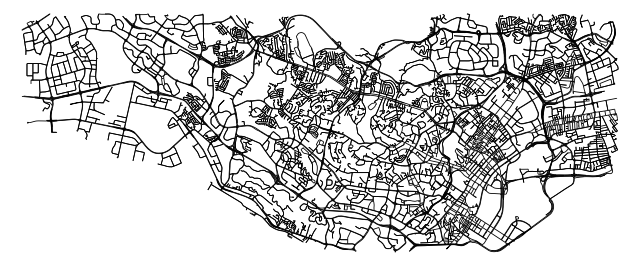

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [53]:
G_planar = planarize_graph(G)
ox.plot_graph(G_planar, node_size=0, edge_color="black", edge_linewidth=0.6, bgcolor="white")

In [54]:
import math

# --- Helper functions -------------------------------------------------------

def _avg_edge_length(graph):
    lengths = [d.get('length') for _, _, d in graph.edges(data=True) if 'length' in d]
    return (sum(lengths) / len(lengths)) if lengths else float('nan')

def percentage_overestimation_intersections(G_orig, G_planar):
    n_orig = G_orig.number_of_nodes()
    n_planar = G_planar.number_of_nodes()
    pct_over = ((n_planar - n_orig) / n_orig * 100.0) if n_orig else float('nan')
    return n_orig, n_planar, pct_over

def percentage_underestimation_avg_edge_length(G_orig, G_planar):
    a_orig = _avg_edge_length(G_orig)
    a_planar = _avg_edge_length(G_planar)
    pct_under = ((a_orig - a_planar) / a_orig * 100.0) if a_orig else float('nan')
    return a_orig, a_planar, pct_under

# --- Calculations -----------------------------------------------------------
orig_nodes, planar_nodes, pct_over_nodes = percentage_overestimation_intersections(G, G_planar)
orig_avg_len, planar_avg_len, pct_under_avg_len = percentage_underestimation_avg_edge_length(G, G_planar)

# --- Output -----------------------------------------------------------------
print("Intersection (node) count — original: {} | planar: {}".format(orig_nodes, planar_nodes))
print("Percentage overestimation of intersections: {:.2f}%".format(pct_over_nodes))
print()
print("Average edge length (m) — original: {:.2f} | planar: {:.2f}".format(orig_avg_len, planar_avg_len))
print("Percentage underestimation of average edge length: {:.2f}%".format(pct_under_avg_len))

Intersection (node) count — original: 9764 | planar: 10618
Percentage overestimation of intersections: 8.75%

Average edge length (m) — original: 120.15 | planar: 109.40
Percentage underestimation of average edge length: 8.95%


(200, 2) (200,)


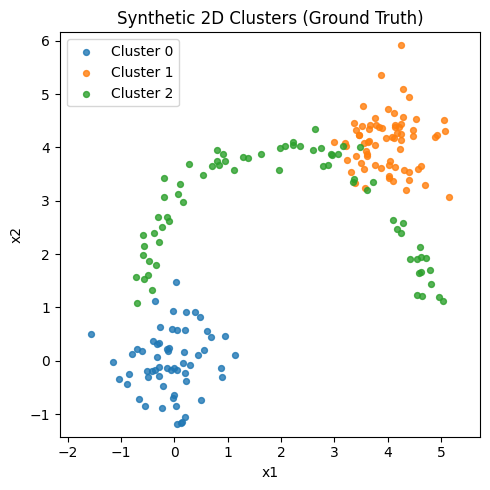

In [55]:
np.random.seed(42)

# Cluster 0: Gaussian near (0,0)
n0 = 60
c0 = np.random.randn(n0, 2) * 0.6 + np.array([0.0, 0.0])

# Cluster 1: Gaussian near (4,4)
n1 = 70
c1 = np.random.randn(n1, 2) * 0.5 + np.array([4.0, 4.0])

# Cluster 2: Crescent (non-spherical)
n2 = 70
theta = np.random.uniform(0, np.pi, n2)
r = 3 + 0.2 * np.random.randn(n2)
x_cres = r * np.cos(theta)
y_cres = r * np.sin(theta)
# Add slight vertical shift and horizontal stretch for shape variety
c2 = np.stack([x_cres * 0.9 + 2.0, y_cres + 1.0], axis=1)

# Combine
X = np.vstack([c0, c1, c2])
y_labels = np.concatenate([
    np.zeros(n0, dtype=int),
    np.ones(n1, dtype=int),
    np.full(n2, 2, dtype=int)
])

print(X.shape, y_labels.shape)

# Plot
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(5,5))
for k in range(3):
    pts = X[y_labels == k]
    plt.scatter(pts[:,0], pts[:,1], s=18, alpha=0.8, label=f'Cluster {k}', c=colors[k])
plt.legend()
plt.title('Synthetic 2D Clusters (Ground Truth)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [56]:
from scipy.spatial import Voronoi

# Assume X (shape (n,2)) already exists from previous task
# If running standalone, uncomment next two lines to mock minimal data
# np.random.seed(0); X = np.random.rand(30,2)

# 1. Compute Voronoi diagram
vor = Voronoi(X)

# 2. Build Delaunay (dual) graph from Voronoi ridge points
G_delaunay = nx.Graph()
G_delaunay.add_nodes_from(range(len(X)))
for a, b in vor.ridge_points:
    G_delaunay.add_edge(int(a), int(b))

print(f"Nodes: {G_delaunay.number_of_nodes()}  Edges: {G_delaunay.number_of_edges()}")

# 3. Plot Voronoi diagram with Delaunay edges and original points
fig, ax = plt.subplots(figsize=(6,6))

# Plot Voronoi edges (finite parts)
for ridge_vertices in vor.ridge_vertices:
    if -1 in ridge_vertices:
        continue  # skip infinite ridges
    pts = vor.vertices[ridge_vertices]
    ax.plot(pts[:,0], pts[:,1], color='lightgray', linewidth=1.0, zorder=1)

# Plot Delaunay edges
for u, v in G_delaunay.edges():
    x_uv = X[[u, v]]
    ax.plot(x_uv[:,0], x_uv[:,1], color='tab:blue', linewidth=0.8, alpha=0.8, zorder=2)

# Plot original points
ax.scatter(X[:,0], X[:,1], c='black', s=18, zorder=3)
ax.set_title('Voronoi Diagram with Delaunay (Dual) Graph')
ax.set_aspect('equal', adjustable='box')
# set the viewing window
margin = 0.5
x_min, x_max = X[:,0].min() - margin, X[:,0].max() + margin
y_min, y_max = X[:,1].min() - margin, X[:,1].max() + margin
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.tight_layout()
plt.show()

Nodes: 200  Edges: 586


Finite regions: 189 / 200
Area threshold (percentile 30): 0.0377
Core points identified: 57


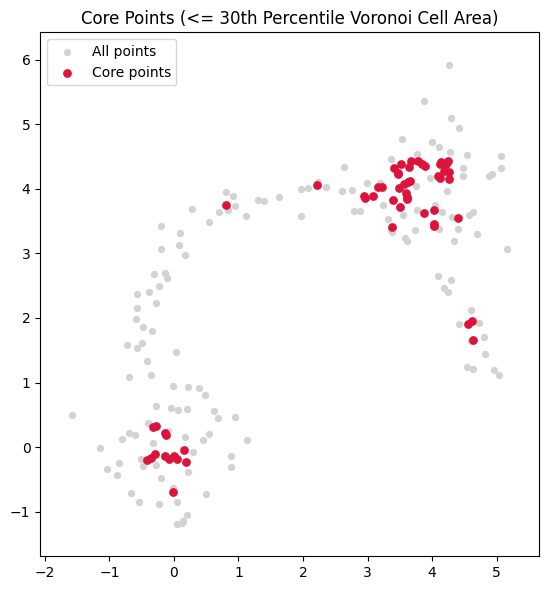

In [57]:
from matplotlib.path import Path

# Number of points
n = len(X)

# Initialize area array with inf
cell_areas = np.full(n, np.inf, dtype=float)
finite_mask = np.zeros(n, dtype=bool)

# Helper to compute polygon area (shoelace) given Voronoi region vertex indices
vertices = vor.vertices
for point_index, region_index in enumerate(vor.point_region):
    region = vor.regions[region_index]
    if -1 in region or len(region) == 0:
        continue  # infinite region
    poly = vertices[region]
    # Shoelace formula
    x = poly[:,0]
    y = poly[:,1]
    area = 0.5 * abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
    cell_areas[point_index] = area
    finite_mask[point_index] = True

# Choose percentile for density threshold (smaller area => higher density)
percentile = 30  # adjust if desired
finite_areas = cell_areas[finite_mask]
area_threshold = np.percentile(finite_areas, percentile)
core_mask = (cell_areas <= area_threshold)

print(f"Finite regions: {finite_mask.sum()} / {n}")
print(f"Area threshold (percentile {percentile}): {area_threshold:.4f}")
print(f"Core points identified: {core_mask.sum()}")

# Visualization: core points highlighted
fig, ax = plt.subplots(figsize=(6,6))
# Plot all points lightly
ax.scatter(X[:,0], X[:,1], c='lightgray', s=18, label='All points', zorder=1)
# Highlight core points
ax.scatter(X[core_mask,0], X[core_mask,1], c='crimson', s=28, label='Core points', zorder=2)
ax.set_title('Core Points (<= 30th Percentile Voronoi Cell Area)')
ax.set_aspect('equal', adjustable='box')
margin = 0.5
x_min, x_max = X[:,0].min() - margin, X[:,0].max() + margin
y_min, y_max = X[:,1].min() - margin, X[:,1].max() + margin
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.legend()
plt.tight_layout()
plt.show()

Core nodes: 57
Detected clusters (components): 9
Cluster sizes: [32, 13, 1, 3, 1, 1, 1, 1, 4]


C:\Users\YuxinLi\AppData\Local\Temp\ipykernel_8928\363822338.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(components))


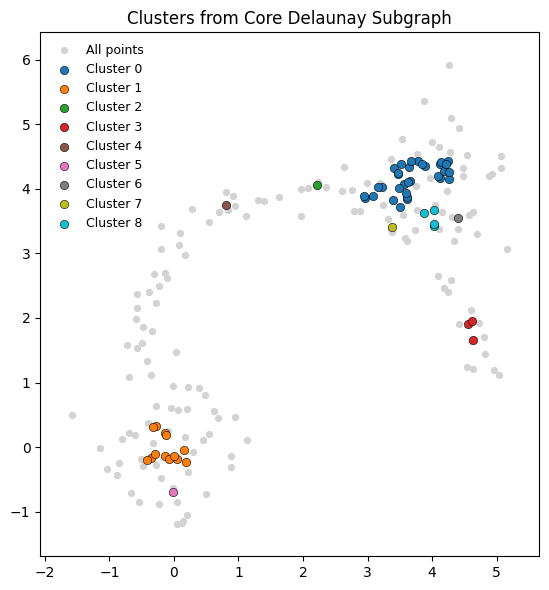

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 1. Core node indices
core_nodes = np.where(core_mask)[0].tolist()

# 2. Induced subgraph
G_core = G_delaunay.subgraph(core_nodes).copy()

# 3. Connected components (clusters)
components = list(nx.connected_components(G_core))
# Map node -> cluster id
node_to_cluster = {}
for cid, comp in enumerate(components):
    for n in comp:
        node_to_cluster[n] = cid

# 4. Build label array: -1 for non-core
core_cluster_labels = np.full(len(X), -1, dtype=int)
for n, cid in node_to_cluster.items():
    core_cluster_labels[n] = cid

print(f"Core nodes: {len(core_nodes)}")
print(f"Detected clusters (components): {len(components)}")
print("Cluster sizes:", [len(c) for c in components])

# 5. Visualization
fig, ax = plt.subplots(figsize=(6,6))
# All points
ax.scatter(X[:,0], X[:,1], c='lightgray', s=18, zorder=1, label='All points')
# Colored core points
if len(components) > 0:
    cmap = plt.cm.get_cmap('tab10', len(components))
    for cid, comp in enumerate(components):
        comp = sorted(comp)
        pts = X[comp]
        ax.scatter(pts[:,0], pts[:,1], s=36, c=[cmap(cid)], label=f'Cluster {cid}', edgecolors='black', linewidths=0.4, zorder=2)

ax.set_title('Clusters from Core Delaunay Subgraph')
ax.set_aspect('equal', adjustable='box')
margin = 0.5
x_min, x_max = X[:,0].min() - margin, X[:,0].max() + margin
y_min, y_max = X[:,1].min() - margin, X[:,1].max() + margin
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.legend(frameon=False, fontsize=9)
plt.tight_layout()
plt.show()